In [23]:
#Step 1: Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
# Set plotting style
plt.style.use('default')
sns.set_palette("viridis")


In [25]:
# Step 2: Load the datasets
# Load Historical Trades Data
df_trades = pd.read_csv('historical_data.csv')
print(" Historical trades data loaded")
print(f"Trades data shape: {df_trades.shape}")

# Load Fear & Greed Index Data
df_sentiment = pd.read_csv('fear_greed_index.csv')
print(" Fear & Greed Index data loaded")
print(f"Sentiment data shape: {df_sentiment.shape}")

 Historical trades data loaded
Trades data shape: (211224, 16)
 Fear & Greed Index data loaded
Sentiment data shape: (2644, 4)


In [27]:
#Step 3: Display basic information about the datasets
print("\n" + "="*50)
print("HISTORICAL TRADES DATA INFO:")
print("="*50)
print(df_trades.info())
print("\nFirst 3 rows:")
print(df_trades.head(3))

print("\n" + "="*50)
print("FEAR & GREED INDEX DATA INFO:")
print("="*50)
print(df_sentiment.info())
print("\nFirst 3 rows:")
print(df_sentiment.head(3))




HISTORICAL TRADES DATA INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  flo

In [29]:
# Step 4: Data Cleaning - Fear & Greed Index Data
print("\n" + "="*50)
print("CLEANING SENTIMENT DATA:")
print("="*50)

# Convert date to datetime
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])

# Check unique sentiment classifications
unique_sentiments = df_sentiment['classification'].unique()
print(f"Unique sentiment classifications: {unique_sentiments}")

# Set date as index for easy merging
df_sentiment.set_index('date', inplace=True)

print("Sentiment data cleaned and ready")


CLEANING SENTIMENT DATA:
Unique sentiment classifications: ['Fear' 'Extreme Fear' 'Neutral' 'Greed' 'Extreme Greed']
Sentiment data cleaned and ready


In [31]:
# Step 5: Data Cleaning - Historical Trades Data
print("\n" + "="*50)
print("CLEANING TRADES DATA:")
print("="*50)

# Convert timestamp to datetime (assuming it's in milliseconds)
df_trades['time'] = pd.to_datetime(df_trades['Timestamp'], unit='ms')

# Create trade_date column for merging
df_trades['trade_date'] = df_trades['time'].dt.date
df_trades['trade_date'] = pd.to_datetime(df_trades['trade_date'])

# Check Closed PnL distribution
print("Closed PnL value counts (top 10):")
print(df_trades['Closed PnL'].value_counts().head(10))

# Filter for completed trades (non-zero Closed PnL)
df_completed_trades = df_trades[df_trades['Closed PnL'] != 0].copy()
print(f"\nOriginal trades: {len(df_trades):,}")
print(f"Completed trades (with realized PnL): {len(df_completed_trades):,}")

# Create performance metrics
df_completed_trades['is_win'] = df_completed_trades['Closed PnL'] > 0
df_completed_trades['net_pnl'] = df_completed_trades['Closed PnL'] - df_completed_trades['Fee']

print("✅ Trades data cleaned and performance metrics created")


CLEANING TRADES DATA:
Closed PnL value counts (top 10):
Closed PnL
 0.000000     106816
 0.146908         80
-1.566400         71
 9.903600         67
 88.459120        62
 0.059631         51
 0.066620         50
 0.095175         50
 1.149000         46
 1.955000         45
Name: count, dtype: int64

Original trades: 211,224
Completed trades (with realized PnL): 104,408
✅ Trades data cleaned and performance metrics created


In [33]:
# Step 6: Merge the datasets
print("\n" + "="*50)
print("MERGING DATASETS:")
print("="*50)

df_merged = df_completed_trades.merge(
    df_sentiment, 
    how='left', 
    left_on='trade_date', 
    right_index=True
)

print(f"Merged dataset shape: {df_merged.shape}")
print(f"Trades with sentiment data: {len(df_merged)}")
print(f"Trades missing sentiment data: {df_merged['value'].isnull().sum()}")

# Remove trades without sentiment data
initial_count = len(df_merged)
df_merged = df_merged.dropna(subset=['value'])
print(f"Removed {initial_count - len(df_merged)} trades without sentiment data")

print(" Datasets merged successfully")


MERGING DATASETS:
Merged dataset shape: (104408, 23)
Trades with sentiment data: 104408
Trades missing sentiment data: 13653
Removed 13653 trades without sentiment data
 Datasets merged successfully


In [35]:
#Step 7: Exploratory Data Analysis
print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS:")
print("="*50)

#Overall Performance Analysis
win_rate = df_merged['is_win'].mean()
avg_pnl = df_merged['net_pnl'].mean()
median_pnl = df_merged['net_pnl'].median()

print("📊 OVERALL PERFORMANCE METRICS:")
print(f"Global Win Rate: {win_rate:.2%}")
print(f"Average Net PnL per trade: ${avg_pnl:.2f}")
print(f"Median Net PnL per trade: ${median_pnl:.2f}")
print(f"Total trades analyzed: {len(df_merged):,}")



EXPLORATORY DATA ANALYSIS:
📊 OVERALL PERFORMANCE METRICS:
Global Win Rate: 85.35%
Average Net PnL per trade: $111.63
Median Net PnL per trade: $6.69
Total trades analyzed: 90,755


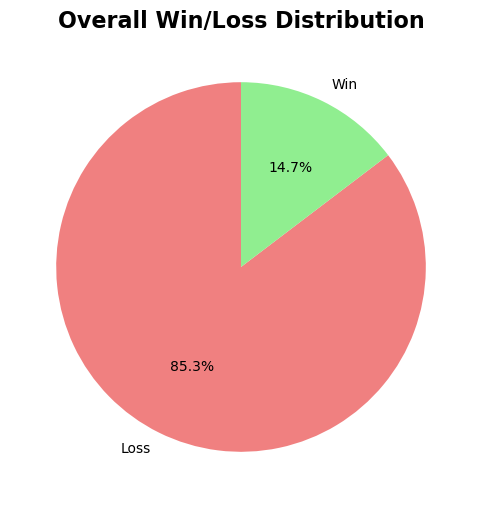

In [37]:
#Plot 1: Win/Loss Distribution
plt.figure(figsize=(10, 6))
win_loss_counts = df_merged['is_win'].value_counts()
colors = ['lightcoral', 'lightgreen']
plt.pie(win_loss_counts.values, labels=['Loss', 'Win'], autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Overall Win/Loss Distribution', fontsize=16, fontweight='bold')
plt.show()


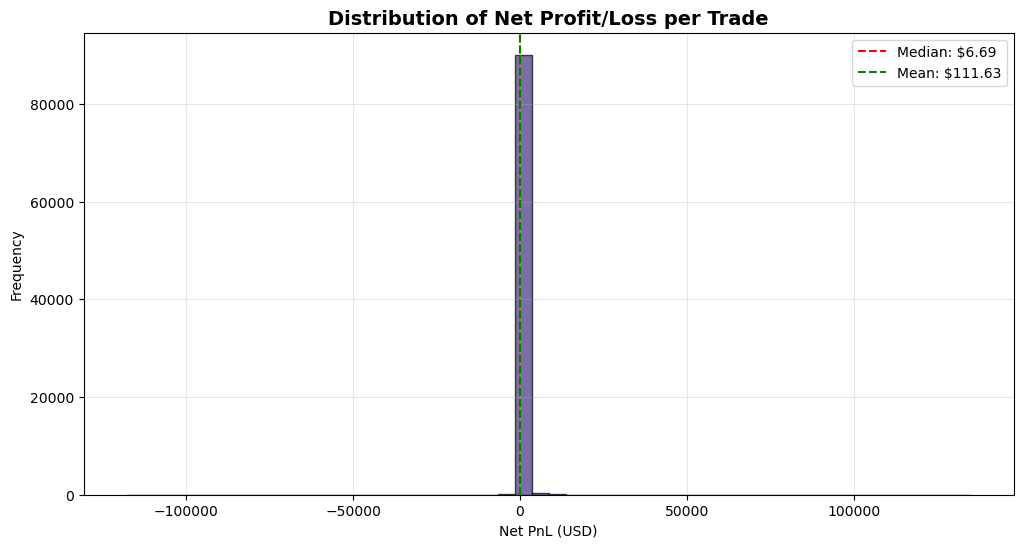

In [39]:
# Plot 2: Distribution of Net PnL
plt.figure(figsize=(12, 6))
plt.hist(df_merged['net_pnl'], bins=50, alpha=0.7, edgecolor='black')
plt.axvline(median_pnl, color='red', linestyle='--', label=f'Median: ${median_pnl:.2f}')
plt.axvline(avg_pnl, color='green', linestyle='--', label=f'Mean: ${avg_pnl:.2f}')
plt.xlabel('Net PnL (USD)')
plt.ylabel('Frequency')
plt.title('Distribution of Net Profit/Loss per Trade', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [43]:
#Performance by Sentiment Category
print("\n" + "="*30)
print("PERFORMANCE BY SENTIMENT")
print("="*30)

# Calculate metrics by sentiment
sentiment_stats = df_merged.groupby('classification').agg({
    'net_pnl': ['count', 'mean', 'median', 'std'],
    'is_win': 'mean',
    'Size USD': 'mean'
}).round(2)

sentiment_stats.columns = ['Trade Count', 'Avg PnL', 'Median PnL', 'Std PnL', 'Win Rate', 'Avg Trade Size']
sentiment_stats = sentiment_stats.sort_values('Avg PnL', ascending=False)

print("Performance Statistics by Sentiment Category:")
print(sentiment_stats)


PERFORMANCE BY SENTIMENT
Performance Statistics by Sentiment Category:
                Trade Count  Avg PnL  Median PnL  Std PnL  Win Rate  \
classification                                                        
Greed                 19075   166.54        7.18  1579.80      0.85   
Fear                  64536   102.67        6.55  1306.09      0.86   
Neutral                2812    55.17        4.77  1010.08      0.81   
Extreme Greed          4332    40.06       10.33   388.09      0.79   

                Avg Trade Size  
classification                  
Greed                  2939.62  
Fear                   5387.50  
Neutral                3905.30  
Extreme Greed          4577.37  


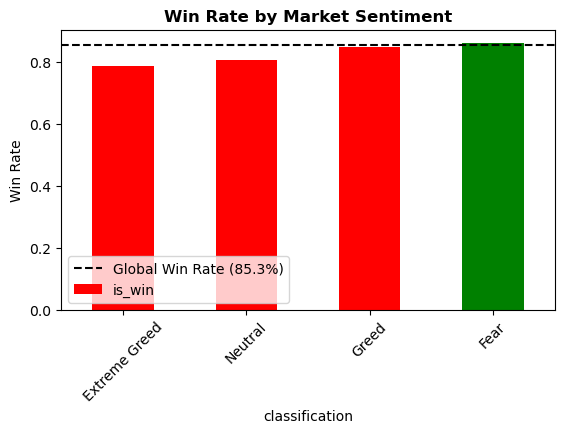

In [45]:
# Plot 3: Win Rate by Sentiment
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
win_rate_by_sentiment = df_merged.groupby('classification')['is_win'].mean().sort_values()
colors = ['green' if rate > win_rate else 'red' for rate in win_rate_by_sentiment.values]
win_rate_by_sentiment.plot(kind='bar', color=colors)
plt.axhline(y=win_rate, color='black', linestyle='--', label=f'Global Win Rate ({win_rate:.1%})')
plt.title('Win Rate by Market Sentiment', fontweight='bold')
plt.ylabel('Win Rate')
plt.xticks(rotation=45)
plt.legend()

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Extreme Greed'),
  Text(1, 0, 'Neutral'),
  Text(2, 0, 'Fear'),
  Text(3, 0, 'Greed')])

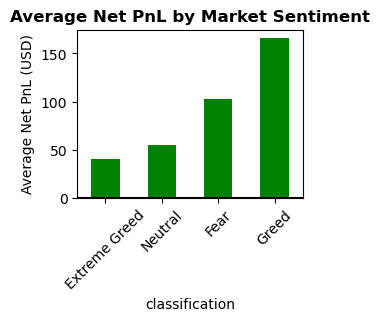

In [47]:
# Plot 4: Average PnL by Sentiment
plt.subplot(2, 2, 2)
avg_pnl_by_sentiment = df_merged.groupby('classification')['net_pnl'].mean().sort_values()
colors = ['green' if pnl > 0 else 'red' for pnl in avg_pnl_by_sentiment.values]
avg_pnl_by_sentiment.plot(kind='bar', color=colors)
plt.axhline(y=0, color='black', linestyle='-')
plt.title('Average Net PnL by Market Sentiment', fontweight='bold')
plt.ylabel('Average Net PnL (USD)')
plt.xticks(rotation=45)


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Fear'),
  Text(1, 0, 'Greed'),
  Text(2, 0, 'Extreme Greed'),
  Text(3, 0, 'Neutral')])

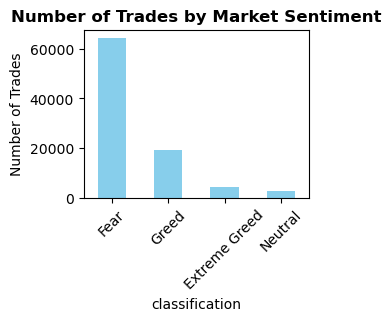

In [49]:
# Plot 5: Trade Count by Sentiment
plt.subplot(2, 2, 3)
trade_count_by_sentiment = df_merged['classification'].value_counts()
trade_count_by_sentiment.plot(kind='bar', color='skyblue')
plt.title('Number of Trades by Market Sentiment', fontweight='bold')
plt.ylabel('Number of Trades')
plt.xticks(rotation=45)

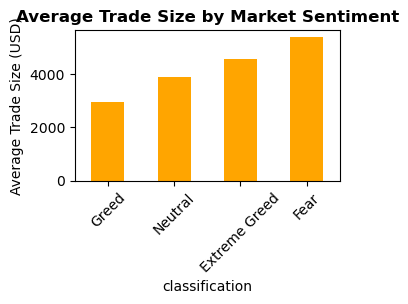

In [51]:
# Plot 6: Average Trade Size by Sentiment
plt.subplot(2, 2, 4)
avg_size_by_sentiment = df_merged.groupby('classification')['Size USD'].mean().sort_values()
avg_size_by_sentiment.plot(kind='bar', color='orange')
plt.title('Average Trade Size by Market Sentiment', fontweight='bold')
plt.ylabel('Average Trade Size (USD)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

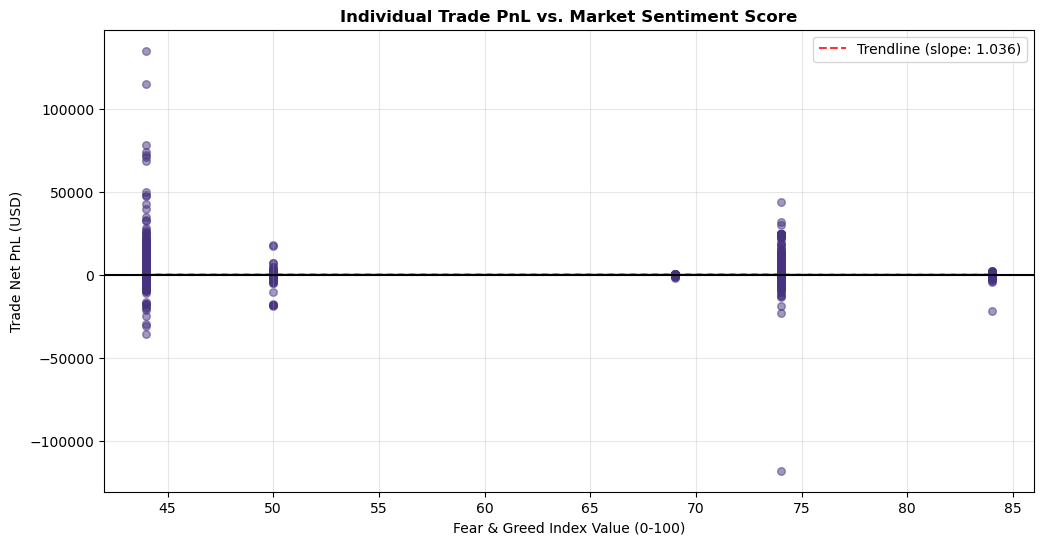

In [53]:
# Scatter Plot: Sentiment Value vs PnL
plt.figure(figsize=(12, 6))
plt.scatter(df_merged['value'], df_merged['net_pnl'], alpha=0.5, s=30)
plt.xlabel('Fear & Greed Index Value (0-100)')
plt.ylabel('Trade Net PnL (USD)')
plt.title('Individual Trade PnL vs. Market Sentiment Score', fontweight='bold')

# Add trendline
z = np.polyfit(df_merged['value'], df_merged['net_pnl'], 1)
p = np.poly1d(z)
plt.plot(df_merged['value'], p(df_merged['value']), "r--", alpha=0.8, 
         label=f'Trendline (slope: {z[0]:.3f})')
plt.axhline(y=0, color='black', linestyle='-')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [55]:
# Calculate correlation
correlation = df_merged['value'].corr(df_merged['net_pnl'])
print(f"📊 Correlation between FGI Value and PnL: {correlation:.3f}")

📊 Correlation between FGI Value and PnL: 0.011


In [63]:
# Step 8: Statistical Analysis
print("\n" + "="*50)
print("STATISTICAL ANALYSIS:")
print("="*50)

# Check if we have extreme sentiment groups
extreme_categories = [cat for cat in df_merged['classification'].unique() if 'Extreme' in cat]
print(f"Extreme sentiment categories found: {extreme_categories}")

if len(extreme_categories) >= 2:
    # Compare Extreme Fear vs Extreme Greed
    extreme_fear = df_merged[df_merged['classification'] == 'Extreme Fear']['net_pnl']
    extreme_greed = df_merged[df_merged['classification'] == 'Extreme Greed']['net_pnl']
    
    if len(extreme_fear) > 10 and len(extreme_greed) > 10:
        # Welch's t-test (doesn't assume equal variances)
        t_stat, p_value = stats.ttest_ind(extreme_fear, extreme_greed, equal_var=False)
        
        print(f"Extreme Fear vs Extreme Greed Comparison:")
        print(f"Extreme Fear trades: {len(extreme_fear)}")
        print(f"Extreme Greed trades: {len(extreme_greed)}")
        print(f"t-statistic: {t_stat:.3f}")
        print(f"p-value: {p_value:.4f}")
        
        if p_value < 0.05:
            print("Significant difference found (p < 0.05)")
        else:
            print("No significant difference found")
    else:
        print( "Not enough data in extreme groups for statistical test")
else:
    print(" Not enough extreme sentiment categories for comparison")


STATISTICAL ANALYSIS:
Extreme sentiment categories found: ['Extreme Greed']
 Not enough extreme sentiment categories for comparison


In [65]:
# Step 9: Key Insights and Conclusion
print("\n" + "="*60)
print("KEY INSIGHTS AND RECOMMENDATIONS:")
print("="*60)

# Find best and worst performing sentiments
best_sentiment = sentiment_stats['Avg PnL'].idxmax()
worst_sentiment = sentiment_stats['Avg PnL'].idxmin()
best_win_rate = sentiment_stats['Win Rate'].idxmax()

print(" KEY FINDINGS:")
print(f"• Most profitable sentiment: {best_sentiment} (${sentiment_stats.loc[best_sentiment, 'Avg PnL']:.2f} avg PnL)")
print(f"• Least profitable sentiment: {worst_sentiment} (${sentiment_stats.loc[worst_sentiment, 'Avg PnL']:.2f} avg PnL)")
print(f"• Highest win rate: {best_win_rate} ({sentiment_stats.loc[best_win_rate, 'Win Rate']:.1%} win rate)")
print(f"• Correlation between FGI value and PnL: {correlation:.3f} (very weak)")

print("\ TRADING RECOMMENDATIONS:")
if sentiment_stats.loc[best_sentiment, 'Avg PnL'] > 0:
    print(f"1. Consider increasing trading activity during {best_sentiment} periods")
if sentiment_stats.loc[worst_sentiment, 'Avg PnL'] < 0:
    print(f"2. Exercise caution or reduce position sizing during {worst_sentiment} periods")
if abs(correlation) < 0.1:
    print("3. Market sentiment (FGI) shows weak direct correlation with individual trade outcomes")
    print("   → Other factors may be more important for trade success")

print("\n" + "="*60)
print("ANALYSIS COMPLETE! ")
print("="*60)


KEY INSIGHTS AND RECOMMENDATIONS:
 KEY FINDINGS:
• Most profitable sentiment: Greed ($166.54 avg PnL)
• Least profitable sentiment: Extreme Greed ($40.06 avg PnL)
• Highest win rate: Fear (86.0% win rate)
• Correlation between FGI value and PnL: 0.011 (very weak)
\ TRADING RECOMMENDATIONS:
1. Consider increasing trading activity during Greed periods
3. Market sentiment (FGI) shows weak direct correlation with individual trade outcomes
   → Other factors may be more important for trade success

ANALYSIS COMPLETE! 
